In [0]:
# import matplotlib
import matplotlib
matplotlib.use("Agg")
%matplotlib inline

# import necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
import matplotlib.pyplot as plt

In [0]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, image dimension, # of classes
EPOCHS = 32
INIT_LR = 1e-3
BS = 16
IMAGE_DIMS = (100, 100, 3)
CLASSES = 10

In [0]:
def _model(width, height, depth, classes):
    
    model = Sequential()
    
    inputShape = (height, width, depth)
    chanDim = -1
    
    # if we are using "channels first", update the input shape
    # and channels dimension
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
      chanDim = 1
      
    # CONV => RELU => POOL
    model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    
    # (CONV => RELU) * 2 => POOL
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # (CONV => RELU) * 2 => POOL
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))
    
    # return the constructed network architecture
    return model

In [157]:
model = _model(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0], depth=IMAGE_DIMS[2], classes=CLASSES)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
activation_54 (Activation)   (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_61 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 33, 33, 32)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 33, 33, 32)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 33, 33, 64)        18496     
_________________________________________________________________
activation_55 (Activation)   (None, 33, 33, 64)        0         
__________

In [0]:
# compiling the model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [159]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/project1/hand-digit_sign/dataset/train/',  # This is the source directory for training images
        target_size=(100, 100),
        batch_size=BS,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

# Flow training images using validation_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/project1/hand-digit_sign/dataset/validation/',  # This is the source directory for validation images
        target_size=(100, 100),
        batch_size=8,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

Found 1662 images belonging to 10 classes.
Found 400 images belonging to 10 classes.


In [160]:
# train the network
print("[INFO] training network...")
H = model.fit_generator(
      train_generator,
      epochs=EPOCHS,
      verbose=1,
      steps_per_epoch=50,
      validation_data = validation_generator,
      validation_steps=8)

[INFO] training network...
Epoch 1/32
50/50 [==============================] - 8s 161ms/step - loss: 1.7474 - acc: 0.5038 - val_loss: 0.7288 - val_acc: 0.7500
Epoch 2/32
50/50 [==============================] - 2s 38ms/step - loss: 0.8976 - acc: 0.7488 - val_loss: 0.7462 - val_acc: 0.7500
Epoch 3/32
50/50 [==============================] - 2s 46ms/step - loss: 0.6111 - acc: 0.8045 - val_loss: 0.5232 - val_acc: 0.8125
Epoch 4/32
50/50 [==============================] - 2s 42ms/step - loss: 0.4756 - acc: 0.8413 - val_loss: 0.6940 - val_acc: 0.8438
Epoch 5/32
50/50 [==============================] - 2s 48ms/step - loss: 0.3566 - acc: 0.8684 - val_loss: 0.4426 - val_acc: 0.8906
Epoch 6/32
50/50 [==============================] - 2s 41ms/step - loss: 0.3694 - acc: 0.8900 - val_loss: 0.3286 - val_acc: 0.8750
Epoch 7/32
50/50 [==============================] - 2s 43ms/step - loss: 0.2645 - acc: 0.9159 - val_loss: 0.3279 - val_acc: 0.9219
Epoch 8/32
50/50 [==============================] - 2s 

In [161]:
# save the model to disk
print("[INFO] saving model...")
model.save('hand-digit-sign-model.model')

[INFO] saving model...


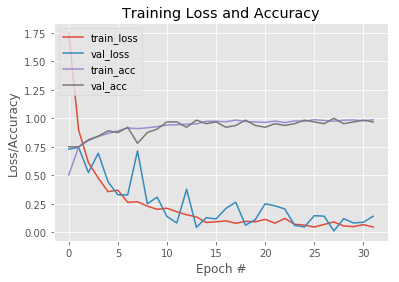

In [162]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig('plot.png')

In [0]:
import numpy as np
from keras.models import load_model
from keras.preprocessing.image import img_to_array
import cv2

In [0]:
# loading model
model = load_model('hand-digit-sign-model.model')

In [0]:
# predicting images

def predict(path):
  image = cv2.imread(path)
  plt.imshow(image)
  image = cv2.resize(image, (100, 100))
  image = image.astype('float') / 255.0
  image = img_to_array(image)
  image = np.expand_dims(image, axis=0)

  prob = model.predict(image)[0]
  id = np.argmax(prob)

  print("{}: {:.2f}%".format(id, prob[id]*100))

9: 74.48%


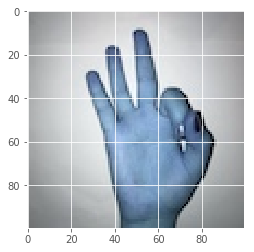

In [175]:
path = '/project1/hand-digit_sign/examples/example_9.JPG'
predict(path)

0: 100.00%


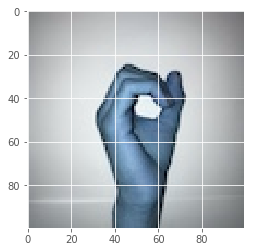

In [177]:
path = '/project1/hand-digit_sign/examples/example_0.JPG'
predict(path)

5: 79.53%


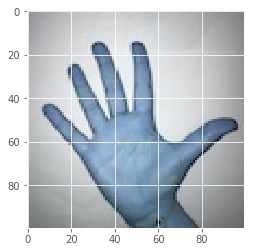

In [178]:
path = '/project1/hand-digit_sign/examples/example_5.JPG'
predict(path)